In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
#from torchsummary import summary
import timeit

## Downloading the CIFAR10 Dataset and Visualization

In [3]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [ ]:
th.manual_seed(43)

# We use about 20% of the dataset for validation.
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print("Data sizes after random splitting -> ", "\nTraining data size = ",len(train_ds), "\nValidation data size = ", len(val_ds))

batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_dataset, batch_size*2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Data sizes after random splitting ->  
Training data size =  40000 
Validation data size =  10000


images.shape: torch.Size([128, 3, 32, 32])
images.shape: torch.Size([128, 3, 32, 32])
images.shape: torch.Size([128, 3, 32, 32])


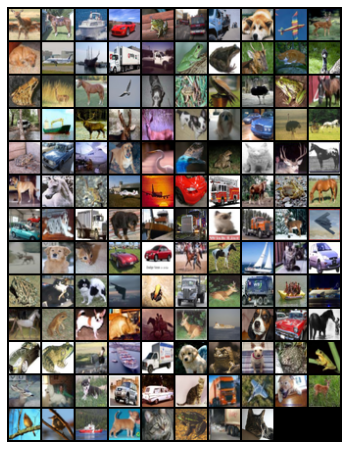

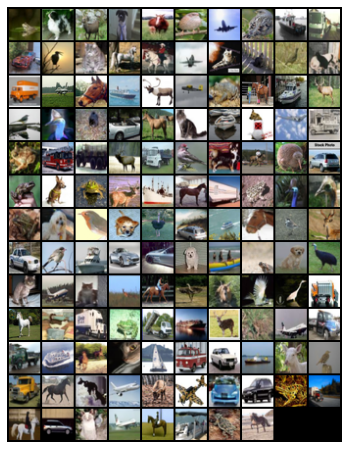

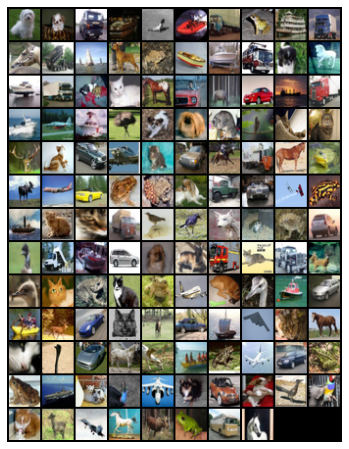

In [ ]:
#Visualization of dataset in batches
for index, (images, labels) in enumerate(train_loader):
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
    if index == 2:  #number of batches to visualize
      break

## Device Settings

In [8]:
device = th.device('cpu')   #cuda or cpu
print(device)
print(th.cuda.device_count())

cpu
1


## Network Class

In [25]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*5*5, 10)
      
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 64*5*5)
        x = self.fc1(x)
        return x

model = Network().to(device=device)

In [27]:
print(model)
#summary(model, (3,32,32))

Network(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=10, bias=True)
)


### With Batch Normalization

In [ ]:
class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv_1_2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.conv_3_4_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5, 10)
      
    def forward(self, x):
        x = F.relu(self.conv_1_2_bn(self.conv1(x)))
        x = F.relu(self.conv_1_2_bn(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.conv_3_4_bn(self.conv3(x)))
        x = F.relu(self.conv_3_4_bn(self.conv4(x)))
        x = self.pool(x)
        x = x.view(-1, 64*5*5)
        x = self.fc1(x)
        return x

model2 = Network2().to(device=device)

## Train Function and Evaluate Function

In [28]:
def train(model, dataloader, optimizer, lossFunction, device=th.device('cpu'), debug=False):
    loss_hist = np.array([])

    for index, (images, labels) in enumerate(dataloader):
        #zero the parameter gradients
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        prediction = model(images)
        loss = lossFunction(prediction, labels)
        loss_hist = np.append(loss_hist, loss.item())
        loss.backward()
        optimizer.step()

        if debug: 
            with th.no_grad():
                if index % 100 == 0:
                    print("{}/{} Loss:{:.6f}".format(index, len(dataloader), loss.item()))

    return loss_hist

def evaluate(model, dataloader, lossFunction, device=th.device('cuda')):   

    total_loss = 0
    total_acc = 0.0

    for index, (images, labels) in enumerate(dataloader):

        images = images.to(device)
        labels = labels.to(device)
        
        prediction = model(images)
        loss = lossFunction(prediction, labels)
        total_loss += loss.item()

        pred_label = th.argmax(prediction, dim=1)  #hardmax
        acc = ((pred_label==labels).sum().item() / len(labels))
        total_acc += acc

    return total_acc/len(dataloader), total_loss/len(dataloader)

## Optimizer and Loss Function

In [29]:
optimizer = th.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95))

lossFunction = th.nn.CrossEntropyLoss()

## Main Module

In [30]:
def main():

    training_loss_hist = np.array([])
    valid_loss_hist = np.array([])
    valid_acc_hist = np.array([])

    epoch = 25

    start_time = timeit.default_timer()

    for i in range(epoch):
          #training
          loss = train(model, train_loader, optimizer, lossFunction, device=device, debug=False)

          #evaluation
          avg_acc, avg_loss = evaluate(model, val_loader, lossFunction, device=device)

          # loss and accuracy histories are kept
          training_loss_hist = np.append(training_loss_hist, loss)
          valid_loss_hist = np.append(valid_loss_hist, avg_loss)
          valid_acc_hist = np.append(valid_acc_hist, avg_acc)

          print("epoch {} evaluation loss: {} evaluation acc: {}".format(i, avg_loss, avg_acc) )

    stop_time = timeit.default_timer()

    print("Time: ", stop_time-start_time)

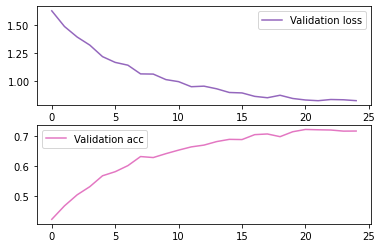

In [ ]:
fig, (axs1, axs2) = plt.subplots(2)
axs1.plot(valid_loss_hist, "tab:purple", label="Validation loss")
axs1.legend()
axs2.plot(valid_acc_hist, "tab:pink", label="Validation acc")
axs2.legend()

In [ ]:
test_acc, test_loss = evaluate(model, val_loader, lossFunction, device=device)
print("test accuracy: {} , test loss: {}".format(test_acc, test_loss))

## Model Saving

In [ ]:
th.save(model.state_dict(), "model")

## Model Loading

In [ ]:
loaded_model = Network().to(device=device)
loaded_model.load_state_dict(th.load("ConvModel"))

loaded_model_acc, loaded_model_loss = evaluate(loaded_model, val_loader, lossFunction)
print("load model validation accuracy: {} , validation loss: {}".format(loaded_model_acc, loaded_model_loss))

load model validation accuracy: 0.7080078125 , validation loss: 0.8647581487894058


## Data Augmentation

In [31]:
rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=5, padding_mode="reflect"),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transformed_dataset = CIFAR10(root='data/', download=True, transform=transform_train)
test_dataset = CIFAR10(root='data/', train=False, transform=transform_train)

Files already downloaded and verified


In [32]:
th.manual_seed(43)
# We use about 20% of the dataset for validation.
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(transformed_dataset, [train_size, val_size])
print("Data sizes after random splitting -> ", "\nTraining data size = ",len(train_ds), "\nValidation data size = ", len(val_ds))

batch_size=128

train_loader= DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_dataset, batch_size*2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Data sizes after random splitting ->  
Training data size =  40000 
Validation data size =  10000


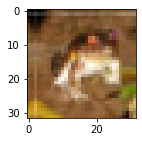

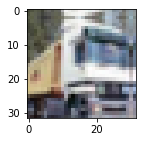

In [24]:
batch_size=1
train_loader_visualize= DataLoader(transformed_dataset, batch_size, shuffle=False)

#Visualization of dataset in batches
for index, (images,labels) in enumerate(train_loader_visualize):
    plt.figure(figsize=(2,2))
    plt.imshow(images.reshape(3,32,32).permute((1, 2, 0)))
    if index == 1:
        break

Do not forget to run the below classes and functions:
- Optimizer
- Network class
- Model 
- Loss Function
- Training and Evaluate Function

In [33]:
main()

epoch 0 evaluation loss: 1.7528407365083694 evaluation acc: 0.3509765625
epoch 1 evaluation loss: 1.6383736968040465 evaluation acc: 0.39453125
epoch 2 evaluation loss: 1.6447308301925658 evaluation acc: 0.408984375
epoch 3 evaluation loss: 1.484218391776085 evaluation acc: 0.45390625
epoch 4 evaluation loss: 1.4520666748285294 evaluation acc: 0.47275390625
epoch 5 evaluation loss: 1.4316814452409745 evaluation acc: 0.48232421875
epoch 6 evaluation loss: 1.3704866975545884 evaluation acc: 0.50830078125
epoch 7 evaluation loss: 1.32817402780056 evaluation acc: 0.52109375
epoch 8 evaluation loss: 1.3298048943281173 evaluation acc: 0.52783203125
epoch 9 evaluation loss: 1.24529949426651 evaluation acc: 0.55673828125
epoch 10 evaluation loss: 1.1756451576948166 evaluation acc: 0.5845703125
epoch 11 evaluation loss: 1.172266425192356 evaluation acc: 0.58505859375
epoch 12 evaluation loss: 1.1997924521565437 evaluation acc: 0.57509765625
epoch 13 evaluation loss: 1.1372832164168358 evaluatio

In [35]:
test_acc, test_loss = evaluate(model, val_loader, lossFunction, device=device)
print("test accuracy: {} , test loss: {}".format(test_acc, test_loss))

test accuracy: 0.66064453125 , test loss: 0.9705039635300636


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, rgb_std),
])

In [ ]:
train_dataloader = th.utils.data.DataLoader(dataset, batch_size=64)


for index, (images,labels) in enumerate(train_dataloader):
      prediction = model(images)
      pred_label = th.argmax(prediction)
    
      if index % 100 == 0:
          print("{}/{}".format(index, len(train_dataloader)))
          print("index: ", index, " len(dataloader): ",len(train_dataloader), " images.shape: ", images.shape, " len(images): ", len(images))
      if index==781:
          print("len images: {}".format(len(images)))

0/782
index:  0  len(dataloader):  782  images.shape:  torch.Size([64, 3, 32, 32])  len(images):  64
100/782
index:  100  len(dataloader):  782  images.shape:  torch.Size([64, 3, 32, 32])  len(images):  64
200/782
index:  200  len(dataloader):  782  images.shape:  torch.Size([64, 3, 32, 32])  len(images):  64
300/782
index:  300  len(dataloader):  782  images.shape:  torch.Size([64, 3, 32, 32])  len(images):  64
400/782
index:  400  len(dataloader):  782  images.shape:  torch.Size([64, 3, 32, 32])  len(images):  64
500/782
index:  500  len(dataloader):  782  images.shape:  torch.Size([64, 3, 32, 32])  len(images):  64
600/782
index:  600  len(dataloader):  782  images.shape:  torch.Size([64, 3, 32, 32])  len(images):  64
700/782
index:  700  len(dataloader):  782  images.shape:  torch.Size([64, 3, 32, 32])  len(images):  64
len images: 16
